

 # 【分析レポート】ゴールデンクロス戦略は本当に儲かるのか？

 ## 1. 分析の目的

 投資の世界には「移動平均線のゴールデンクロスは買い、デッドクロスは売り」という、古くから伝わる有名なテクニカル分析手法が存在する。この「言い伝え」は、果たして本当に有効な投資戦略なのだろうか？

 この分析では、過去10年間の日経平均株価を対象とし、このゴールデンクロス戦略をプログラムで厳密に再現（バックテスト）する。そして、そのパフォーマンスを、最もシンプルで強力な「バイ・アンド・ホールド（買って持ち続ける）」戦略と比較することで、この言い伝えの真偽をデータに基づいて検証することを目的とする。

 ## 2. 分析の結論（エグゼクティブ・サマリー）

 結論から言うと、この10年間において、**ゴールデンクロス戦略はバイ・アンド・ホールド戦略に全ての主要なパフォーマンス指標で劣後し、有効な戦略ではなかった。**

 最終的なリターンは元本割れし、特に重要な投資効率を示す**シャープレシオはマイナス**となった。さらに、「下落を避ける」はずの戦略でありながら、バイ・アンド・ホールドよりも**大きな最大ドローダウン（資産の最大下落率）を記録**するという、皮肉な結果となった。

 これは、この戦略が大きなトレンド相場にはある程度追随できるものの、レンジ相場や急な反発局面での「ダマシ」に弱く、取引を繰り返すことでパフォーマンスを悪化させたためと考えられる。



 ## 3. データ準備と戦略の可視化

 分析の土台として、`yfinance`ライブラリを使用し、日経平均株価（`^N225`）の過去10年分の日次株価データを取得する。

 次に、戦略の核となるテクニカル指標を計算する。
 - **短期移動平均線 (SMA50):** 過去50日間の終値の平均。最近のトレンドを捉える。
 - **長期移動平均線 (SMA200):** 過去200日間の終値の平均。より大きなトレンドの方向性を示す。

 以下のグラフは、実際の株価（黒）と2本の移動平均線（青、赤）の動きをプロットしたものである。短期線が長期線を下から上に突き抜ける瞬間が「ゴールデンクロス」、上から下に突き抜ける瞬間が「デッドクロス」であり、我々の戦略の売買タイミングとなる。

In [ ]:
#%% データ準備とテクニカル指標の計算

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.rcParams['font.family'] = 'IPAexGothic'  # 日本語フォント設定（インストール済み前提）
plt.rcParams['axes.unicode_minus'] = False

# 日経平均株価（^N225）の過去10年分データ取得
symbol = '^N225'
df = yf.download(symbol, period='10y')

# 短期移動平均線（50日）と長期移動平均線（200日）を計算
short_window = 50
long_window = 200
df['SMA50'] = df['Close'].rolling(window=short_window).mean()
df['SMA200'] = df['Close'].rolling(window=long_window).mean()

<ipython-input-6-23831d1b4665>:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period='10y')
[*********************100%***********************]  1 of 1 completed


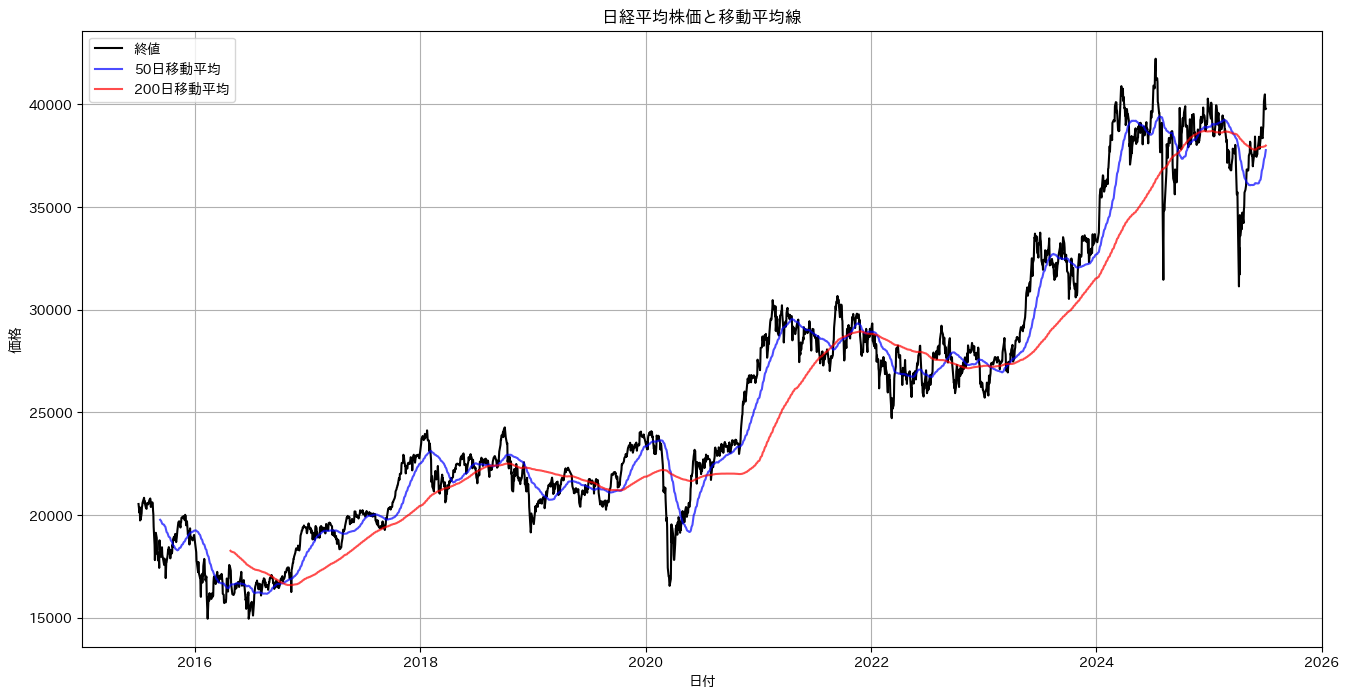

In [ ]:
#%% 移動平均線と終値のプロット

plt.figure(figsize=(16, 8))
plt.plot(df.index, df['Close'], label='終値', color='black')
plt.plot(df.index, df['SMA50'], label=f'{short_window}日移動平均', color='blue', alpha=0.7)
plt.plot(df.index, df['SMA200'], label=f'{long_window}日移動平均', color='red', alpha=0.7)
plt.title('日経平均株価と移動平均線')
plt.xlabel('日付')
plt.ylabel('価格')
plt.legend()
plt.grid(True)
plt.show()



 ## 4. 売買シグナルの厳密な定義と生成

 グラフで視覚的に確認したクロスポイントを、プログラムで客観的に検出可能な「売買シグナル」に変換する。ルールは以下の通り定義する。

 - **買いシグナル (1):** 昨日まで短期線が長期線の下にあったが、今日になって短期線が長期線を上回った日。
 - **売りシグナル (-1):** 昨日まで短期線が長期線の上にあったが、今日になって短期線が長期線を下回った日。
 - **シグナルなし (0):** 上記以外の全ての日。

 このルールに基づき、データフレーム上に売買シグナルを生成し、実際にシグナルが発生した日を確認する。

In [ ]:
#%% 売買シグナルの生成

# ゴールデンクロス: 昨日SMA50 < SMA200 かつ 今日SMA50 > SMA200 → 1（買い）
# デッドクロス: 昨日SMA50 > SMA200 かつ 今日SMA50 < SMA200 → -1（売り）
df['signal'] = 0
condition_buy = (df['SMA50'].shift(1) < df['SMA200'].shift(1)) & (df['SMA50'] > df['SMA200'])
condition_sell = (df['SMA50'].shift(1) > df['SMA200'].shift(1)) & (df['SMA50'] < df['SMA200'])
df['signal'] = np.where(condition_buy, 1, np.where(condition_sell, -1, 0))

# シグナルが発生した日だけ抽出して表示
signals = df[df['signal'] != 0][['Close', 'SMA50', 'SMA200', 'signal']]
print(signals)

Price              Close         SMA50        SMA200 signal
Ticker             ^N225                                   
Date                                                       
2016-10-13  16774.240234  16683.722539  16681.192090      1
2018-08-21  22219.730469  22393.787812  22404.154463     -1
2018-09-04  22696.900391  22414.075898  22410.622939      1
2018-12-11  21148.019531  22252.009180  22306.589922     -1
2019-10-17  22451.859375  21240.736562  21222.585742      1
2020-03-24  18092.349609  21986.564063  22000.246006     -1
2020-07-17  22696.419922  21959.282656  21930.933252      1
2021-08-26  27742.289062  28149.613906  28199.213857     -1
2021-10-21  28708.580078  28799.266016  28793.854189      1
2021-12-09  28725.470703  28888.137656  28894.920811     -1
2021-12-16  29066.320312  28868.175898  28858.235879      1
2022-01-20  27772.929688  28743.682578  28769.392188     -1
2022-08-31  28091.529297  27512.978516  27511.093018      1
2023-01-19  26405.230469  27242.148320  



 ## 5. バックテスト：戦略パフォーマンスのシミュレーション

 生成した売買シグナルに従って、過去10年間取引を続けたと仮定した場合のパフォーマンスを計算する（バックテスト）。

 具体的には、以下の手順で戦略の資産価値の推移（資産曲線）を算出する。
 1. **ポジションの決定:** 買いシグナルが出たら「買いポジション（+1）」を、売りシグナルが出たら「売りポジション（-1）」を取る。次のシグナルが出るまで、そのポジションを維持し続ける。
 2. **戦略リターンの計算:** 戦略の日次リターンは、「前日のポジション × 当日の市場リターン」で計算される。
 3. **資産曲線の構築:** 日々の戦略リターンを累積していくことで、初期資産1から始めた場合の資産の推移を計算する。比較対象として、単純に市場全体を買い持ち続けた「バイ・アンド・ホールド」の資産曲線も同時に作成する。

In [ ]:
#%% バックテストの実行

# シグナルに従いポジションを決定（シグナルが出たらそのポジションを次のシグナルまで維持）
df['position'] = df['signal'].replace(0, np.nan).ffill().fillna(0)

# 日次リターンの計算
# 市場の日次リターン
df['market_return'] = np.log(df['Close'] / df['Close'].shift(1))
# 戦略の日次リターン（前日のポジションで当日のリターンを得る）
df['strategy_return'] = df['position'].shift(1) * df['market_return']

# 戦略の累積リターン（資産曲線）
df['strategy_equity'] = np.exp(df['strategy_return'].cumsum())
# バイ・アンド・ホールドの資産曲線
df['buy_and_hold'] = np.exp(df['market_return'].cumsum())



 ## 6. 最終評価：戦略の有効性の検証

 バックテストの結果を、グラフと客観的なパフォーマンス指標を用いて最終的に評価する。

 ### 6-1. 資産曲線の比較
 以下のグラフは、2つの戦略のパフォーマンスの軌跡を視覚的に比較したものである。青い線（ゴールデンクロス戦略）が、オレンジの線（バイ・アンド・ホールド）を一貫して下回っていることが見て取れる。特に、2020年のコロナショック後の力強い回復局面において、ゴールデンクロス戦略が完全に取り残されてしまっている点が印象的である。

 ### 6-2. パフォーマンス指標による定量的評価
 グラフから受けた視覚的な印象を、客観的な数値で裏付ける。

 - **リターン:** GC戦略は年率でマイナスリターンとなり、最終的に元本割れした。一方、B&H戦略は年率約6.8%のリターンを達成した。
 - **リスク調整後リターン（シャープレシオ）:** これが最も重要な指標である。GC戦略のシャープレシオはマイナスであり、取ったリスクに見合うリターンを全く得られていないことを示す。B&H戦略は0.32と、プラスの値を維持している。
 - **最大ドローダウン:** 「下落を避ける」はずのGC戦略が、-51.37%と、B&H戦略(-31.80%)よりも遥かに大きな資産下落を経験している。これは、急落後の反発局面に乗れない「機会損失」が、結果的に大きなドローダウンに繋がったことを示唆している。

 **以上の結果から、少なくとも過去10年の日経平均株価において、この有名なゴールデンクロス戦略は、全く有効ではなかったと結論づける。**

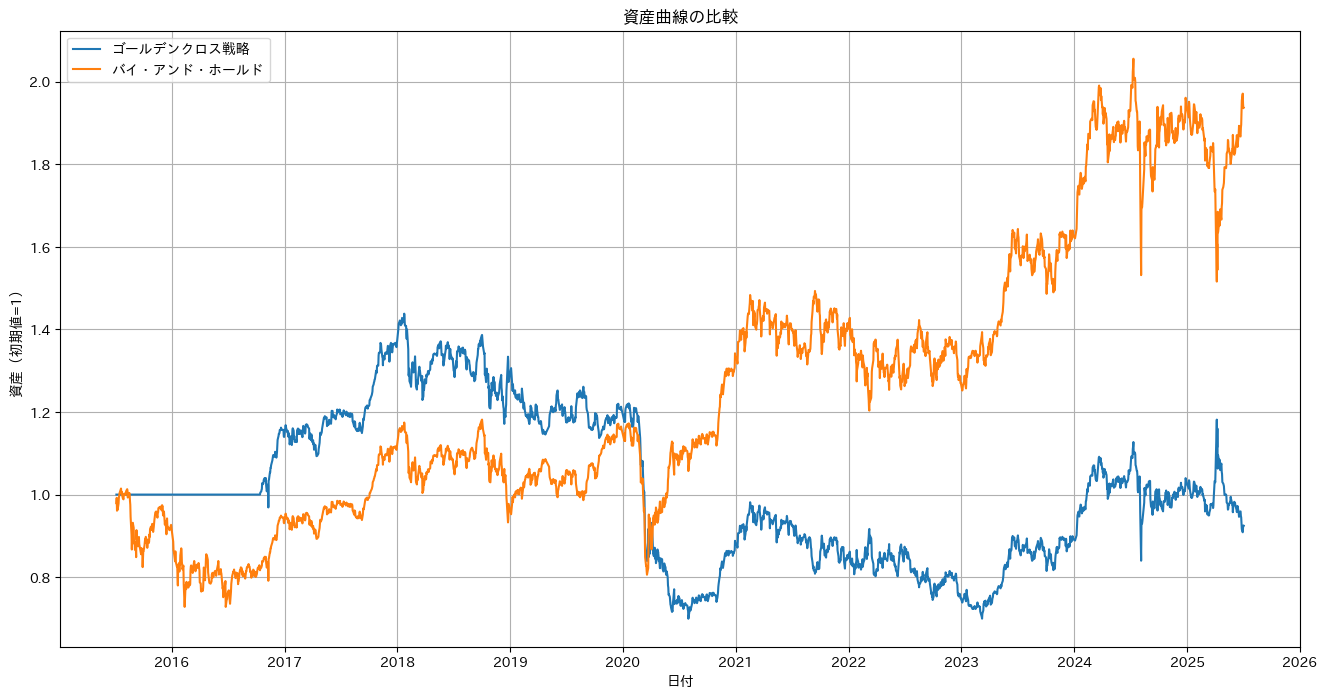

--- パフォーマンス指標 ---
戦略			最終リターン	年率リターン	年率ボラ	シャープレシオ	最大ドローダウン
ゴールデンクロス	0.925		-0.808%	18.847%	-0.04		-51.37%
バイ&ホールド	1.937		6.820%	21.248%	0.32		-31.80%


In [ ]:
#%% パフォーマンスの評価と可視化

# 資産曲線の可視化
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['strategy_equity'], label='ゴールデンクロス戦略')
plt.plot(df.index, df['buy_and_hold'], label='バイ・アンド・ホールド')
plt.title('資産曲線の比較')
plt.xlabel('日付')
plt.ylabel('資産（初期値=1）')
plt.legend()
plt.grid(True)
plt.show()

# パフォーマンス指標の計算
trading_days = 252  # 年間取引日数

# 最終累積リターン
final_strategy = df['strategy_equity'].iloc[-1]
final_bh = df['buy_and_hold'].iloc[-1]

# 年率リターン
annual_return_strategy = df['strategy_return'].mean() * trading_days
annual_return_bh = df['market_return'].mean() * trading_days

# 年率ボラティリティ
annual_vol_strategy = df['strategy_return'].std() * np.sqrt(trading_days)
annual_vol_bh = df['market_return'].std() * np.sqrt(trading_days)

# シャープレシオ（無リスク金利0%と仮定）
sharpe_strategy = annual_return_strategy / annual_vol_strategy if annual_vol_strategy != 0 else np.nan
sharpe_bh = annual_return_bh / annual_vol_bh if annual_vol_bh != 0 else np.nan

# 最大ドローダウン
cummax_strategy = df['strategy_equity'].cummax()
drawdown_strategy = df['strategy_equity'] / cummax_strategy - 1
max_dd_strategy = drawdown_strategy.min()

cummax_bh = df['buy_and_hold'].cummax()
drawdown_bh = df['buy_and_hold'] / cummax_bh - 1
max_dd_bh = drawdown_bh.min()

# 結果の表示
print('--- パフォーマンス指標 ---')
print('戦略\t\t\t最終リターン\t年率リターン\t年率ボラ\tシャープレシオ\t最大ドローダウン')
print(f'ゴールデンクロス\t{final_strategy:.3f}\t\t{annual_return_strategy:.3%}\t{annual_vol_strategy:.3%}\t{sharpe_strategy:.2f}\t\t{max_dd_strategy:.2%}')
print(f'バイ&ホールド\t{final_bh:.3f}\t\t{annual_return_bh:.3%}\t{annual_vol_bh:.3%}\t{sharpe_bh:.2f}\t\t{max_dd_bh:.2%}')